Checking the counts of the images

In [4]:
import os

directory = "annotations" # directory where the txt files are located
files = os.listdir(directory) # get the list of all files in the directory

counts = []
for file in files:
    if file.endswith(".txt"): # check if the file is a txt file
        path = os.path.join(directory, file) # get the full path of the file
        with open(path, 'r') as f:
            num_rows = sum(1 for line in f) # count the number of rows in the file
            print(f"{file}: {num_rows}")
            counts.append(num_rows)

total_samples = sum(counts)
class_weights = np.array([total_samples / count for count in counts])
class_weights /= class_weights.sum() # normalize the weights to sum to 1
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print(f'example class init weights: {class_weights}')

night.txt: 598
people.txt: 6403
baby.txt: 95
female.txt: 3227
flower.txt: 761
car.txt: 319
portrait.txt: 3121
bird.txt: 360
clouds.txt: 1095
dog.txt: 448
male.txt: 2979
river.txt: 120
tree.txt: 525
sea.txt: 173
example class init weights: [0.04211008 0.00393282 0.26507189 0.00780348 0.03309045 0.0789399
 0.00806851 0.06994953 0.0229971  0.05620944 0.00845311 0.20984858
 0.04796539 0.14555971]


## Multi-class classifier

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
import torch.backends.mps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
import torchvision.transforms as transforms

import pandas as pd

In [28]:
#--- hyperparameters ---
N_EPOCHS = 10
LR = 0.01
DROPOUT_RATE = 0.3

#--- fixed constants ---
NUM_CLASSES = 14
DATA_DIR = 'dataset/%s'
NUM_CHANNELS = 3
WIDTH, HEIGHT = 128, 128
MEAN = [0.45183619, 0.4171191, 0.3778775 ]
SD = [0.24016619, 0.23024313, 0.22750713]

In [41]:
val_transform = transforms.Compose([
                                        #transforms.Grayscale(),
                                        #transforms.Resize(256),
                                        #transforms.CenterCrop(128),
                                        transforms.ToTensor()])
                                        #transforms.Normalize(MEAN, SD)])

test_transform = transforms.Compose([
                                        transforms.ToTensor()])#,
                                        #transforms.Normalize(MEAN, SD)])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    #transforms.RandomResizedCrop(size=128),
    transforms.ToTensor()#,
    #transforms.Normalize(MEAN, SD)
])


## V3

In [44]:
#def stratified_train_test_split(data, labels, test_size=0.2, random_state=42):
#    # Create a StratifiedShuffleSplit object and split the dataset into train and test
#    
#    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
#    train_val_indices, test_indices = next(sss.split(data, labels))
#    train_indices, val_indices = next(sss.split(train_val_indices, labels[train_val_indices]))
#
#
#    # Create train and test datasets from the indices generated by StratifiedShuffleSplit
#    train_dataset = Subset(dataset, train_indices)
#    test_dataset = Subset(dataset, test_indices)
#    val_dataset = Subset(dataset, val_indices)
#        
#    return train_dataset, test_dataset, val_dataset


#def stratified_train_test_split(dataset, test_size=0.2, random_state=42):
#    # Create a StratifiedShuffleSplit object and split the dataset into train and test
#    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
#    train_val_indices, test_indices = next(sss.split(dataset.image_paths, dataset.labels_df))
#    train_indices, val_indices = next(sss.split(train_val_indices, dataset.labels_df.iloc[train_val_indices]))
#
#    # Create train and test datasets from the indices generated by StratifiedShuffleSplit
#    train_dataset = Subset(dataset, train_indices)
#    test_dataset = Subset(dataset, test_indices)
#    val_dataset = Subset(dataset, val_indices)
#        
#    return train_dataset, test_dataset, val_dataset
#

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, alt_transform=None, skip_label='', min_samples_per_class=1500):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(os.path.join(self.root_dir, "images"))
        self.labels = {}
        for label in ['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']:
            if label in skip_label:
                continue
            with open(os.path.join(self.root_dir, "annotations", f"{label}.txt"), "r") as f:
                f.seek(0)
                self.labels[label] = set(f.read().splitlines())

        # Check the number of samples per class and augment data for the classes that have less than min_samples_per_class
        self.labels_df = pd.DataFrame(self.get_labels(), columns=self.labels.keys())
        #class_counts = self.labels_df.sum()
        #for index, (label, count) in enumerate(class_counts.items()):
        #    if count < min_samples_per_class:
        #        if alt_transform is not None:
        #            augmented_samples = self.augment_data(self.labels[label], alt_transform)
        #            #print(augmented_samples, self.labels[label])
        #            #print(f'union: {self.labels[label].union(augmented_samples)}')
        #            self.labels[label] = self.labels[label].union(augmented_samples)
        #            #print(f'adding: {augmented_samples}')
        #            #print(f'to {self.image_paths}')
        #            self.image_paths.extend([f"_{sample}_altered.jpg" for sample in augmented_samples])
        #print('After data augmentation:')
        #print('self.image_paths:', self.image_paths)
        #print('self.labels_df:', self.labels_df)

                
    #def augment_data(self, samples, transforms):
    #  augmented_samples = set()
    #  for sample in samples:
    #      image_path = os.path.join(self.root_dir, "images", f"im{sample}.jpg")
    #      image = Image.open(image_path).convert("RGB")
    #      for transform in transforms:
    #          transformed_image = transform(image)
    #          transformed_image_path = os.path.join(self.root_dir, "images", f"_{sample}_{transform.__class__.__name__}.jpg")
    #          transformed_image.save(transformed_image_path)
    #          #transformed_sample = transformed_image_path.split("/")[1]
    #          transformed_sample = int(os.path.basename(transformed_image_path)[1:].split("_")[0])
    #          #print(f'added: {transformed_sample}')
    #          augmented_samples.add(transformed_sample)
    #  return augmented_samples
                  
    def get_labels(self):
        labels = []
        for i in range(len(self)):
            image_path = os.path.join(self.root_dir, "images", self.image_paths[i])
            label = []
            for key, value in self.labels.items():
                filename = os.path.basename(image_path)[2:-4]
                label.append(1 if filename in value else 0)
            labels.append(label)
        return np.array(labels)
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, "images", self.image_paths[index])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels_df.iloc[index].values
        
        label = torch.tensor(label, dtype=torch.float32)
        
        return image, label, index, image_path



#skip_labels= ['baby', 'bird', 'car', 'clouds', 'dog', 'flower', 'night', 'river', 'sea', 'tree']
# Instantiate dataset
path = ""

dataset = CustomDataset(root_dir="")

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

#augmented_dataset = CustomDataset(root_dir="")
print('dataset loaded')
#dataset_merged = torch.utils.data.ConcatDataset([dataset, augmented_dataset])

# Split dataset into train and test using stratified sampling (+ validation)
#train_dataset, test_dataset, val_dataset = stratified_train_test_split(, test_size=0.2, random_state=42)
#train_aug_dataset, test_aug_dataset, val_aug_dataset = stratified_train_test_split(augmented_dataset, test_size=0.2, random_state=42)
#train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#train_dataset_merged = torch.utils.data.ConcatDataset([train_aug_dataset, train_dataset])
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

test_dataset.dataset.transform = test_transform
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create data loaders for each set
sampler = WeightedRandomSampler(class_weights_tensor, len(dataset))
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataset loaded


In [43]:
class MultiLabelClassifier(nn.Module):
    def __init__(self):
        super(MultiLabelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(NUM_CHANNELS, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
        self.drop = nn.Dropout(p=DROPOUT_RATE)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.drop(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ComplexMultiLabelClassifier(nn.Module):
    def __init__(self):
        super(ComplexMultiLabelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.drop1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU(inplace=True)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256, NUM_CLASSES)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.drop2(x)
        x = self.fc3(x)
        #x = self.sigmoid(x)
        return x

class SimpleMultiLabelClassifier(nn.Module):
    def __init__(self):
        super(SimpleMultiLabelClassifier, self).__init__()
        self.conv = nn.Conv2d(NUM_CHANNELS, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 64 * 64, NUM_CLASSES)
        self.drop = nn.Dropout(p=DROPOUT_RATE)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv(x)))
        x = x.view(-1, 16 * 64 * 64)
        x = self.drop(x)
        x = self.fc(x)
        x = self.drop(x)
        return x

    
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        return torch.mean(focal_loss)

class FocalLossV2(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLossV2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)        


In [45]:
device = torch.device('cpu')

# set up device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        device = torch.device('mps')

print(device)

model = ComplexMultiLabelClassifier().to(device)

# Define loss function and optimizer
criterion = FocalLossV2(alpha=class_weights_tensor)
#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
optimizer = optim.Adam(model.parameters(), lr=LR)

# parameters for early stop
threshold = 4       # number of epochs to wait if test loss doesnt improve
min_loss = np.inf
counter = 0

# Train your model
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0
    total_zero = 0

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels, index, path = data
        #print(inputs.size())
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        # calculate accuracy
        predictions = (torch.sigmoid(outputs) > 0.5).int()
        correct = torch.eq(predictions, labels).sum().item()

        train_correct += correct

        # En oo iha varma miten tätä pitäs tulkita, atm laskee siis jokasen oikeen arvauksen ja yhen kuvan sisällä on käytännössä 14 arvausta
        train_total += labels.size(0)*NUM_CLASSES
        loss = criterion(outputs, labels)
        train_loss += loss
        loss.backward()
        optimizer.step()

        if predictions.sum() == 0:
            total_zero += 1

    # calculate average loss and accuracy for epoch
    epoch_loss = train_loss / len(train_loader)
    epoch_accuracy = train_correct / train_total
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy*100:.2f}%')
    print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

    model.eval()
    # evaluate model on validation set
    with torch.no_grad():
        val_loss = 0
        val_correct = 0
        val_total = 0
        total_zero = 0

        for i, data in enumerate(val_loader):
            inputs, labels, index, path = data
            inputs, labels = inputs.to(device), labels.to(device)
        
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            # calculate accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).int()
            correct = torch.eq(predictions, labels).sum().item()
            val_correct += correct

            val_total += labels.size(0)*NUM_CLASSES
            val_loss += loss

            if predictions.sum() == 0:
                total_zero += 1

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

    # early stopping
    if val_loss < min_loss:
        min_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= threshold:
            print(f'Stopping early after epoch {epoch}, best loss reached.')
            break
            

cpu
Epoch: 01
	Train Loss: 0.014 | Train Acc: 99.02%
	 Total Zero: 0  |  Zero Rate: 0.00%
	 Val. Loss: 0.105 |  Val. Acc: 89.68%
	 Total Zero: 0  |  Zero Rate: 0.00%


KeyboardInterrupt: 

In [38]:
torch.save(model.state_dict(), 'FocalAndAdamSimpleEpochs5.pth')

In [ ]:
model = MultiLabelClassifier().to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [39]:
#--- test ---
model.eval()
with torch.no_grad():
    test_loss = 0
    test_correct = 0
    test_total = 0
    total_zero = 0
    for i, data in enumerate(test_loader):
        inputs, labels, index, path = data
        inputs, labels = inputs.to(device), labels.to(device)
        #print(labels.shape)
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        # calculate accuracy
        predictions = (outputs > 0.5).int()
        
        correct = torch.eq(predictions, labels).sum().item()
        test_correct += correct

        test_total += labels.size(0)*NUM_CLASSES
        test_loss += loss

        if predictions.sum() == 0:
            total_zero += 1

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')
print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

Test Loss: 0.023 |  Test Acc: 92.17%
	 Total Zero: 1  |  Zero Rate: 1.59%


raw: tensor([[-8.6090, -9.4622, -9.9815, -9.7575, -9.6647, -7.0720, -9.4447, -2.5603,
         -9.6010, -1.2023, -0.3130, -9.8983, -9.7353, -4.6448]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.8242e-04, 7.7726e-05, 4.6244e-05, 5.7857e-05, 6.3483e-05, 8.4778e-04,
         7.9105e-05, 7.1735e-02, 6.7660e-05, 2.3106e-01, 4.2238e-01, 5.0256e-05,
         5.9155e-05, 9.5202e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


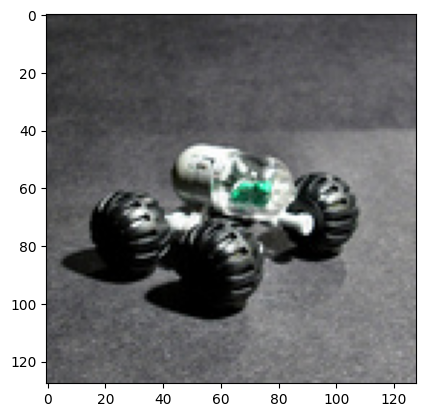

raw: tensor([[ -3.1190,  -8.9921, -10.1563,  -9.8505,  -9.1519,  -6.1053,  -8.7128,
          -4.7693,  -9.1133,  -1.2432,  -1.5246, -10.0443,  -9.8133,  -2.8856]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[4.2331e-02, 1.2437e-04, 3.8827e-05, 5.2716e-05, 1.0600e-04, 2.2261e-03,
         1.6444e-04, 8.4151e-03, 1.1018e-04, 2.2388e-01, 1.7878e-01, 4.3430e-05,
         5.4715e-05, 5.2872e-02]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


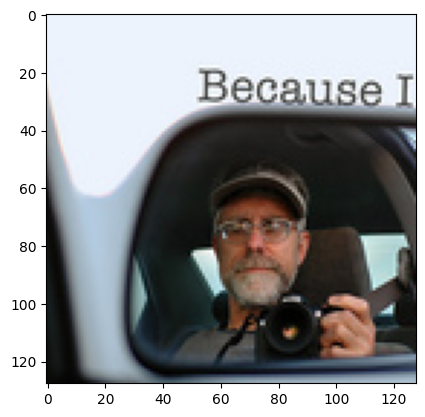

raw: tensor([[-4.6201, -6.9150, -8.2920, -7.7001, -6.7368, -5.2716, -6.7129, -5.8257,
         -7.0850, -1.3030, -1.9818, -7.9945, -7.8068, -2.4542]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0098, 0.0010, 0.0003, 0.0005, 0.0012, 0.0051, 0.0012, 0.0029, 0.0008,
         0.2137, 0.1211, 0.0003, 0.0004, 0.0791]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


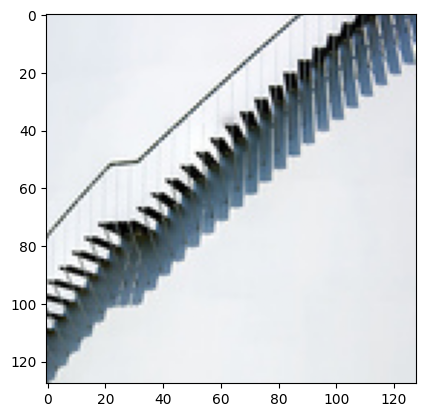

raw: tensor([[ -4.1409, -12.0337, -13.6462, -13.1359, -12.4288,  -9.2100, -11.8427,
          -5.5717, -12.4435,  -2.4290,  -1.6769, -13.3894, -13.0902,  -6.4350]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.5659e-02, 5.9406e-06, 1.1845e-06, 1.9731e-06, 4.0017e-06, 1.0002e-04,
         7.1910e-06, 3.7898e-03, 3.9433e-06, 8.0989e-02, 1.5751e-01, 1.5313e-06,
         2.0654e-06, 1.6018e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


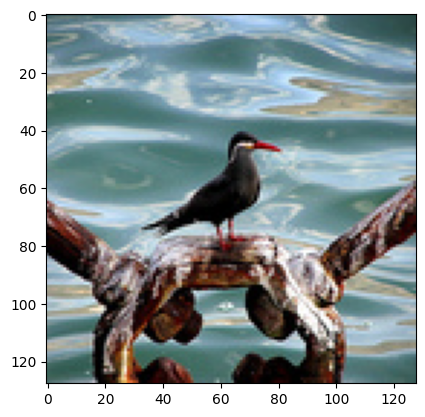

raw: tensor([[ -6.7201, -33.8036, -36.8878, -36.2336, -33.7399, -10.8970, -33.2961,
          -6.1937, -34.4401,  -5.0399,  -7.9012, -36.5968, -36.1722, -17.4070]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.2050e-03, 2.0858e-15, 9.5459e-17, 1.8364e-16, 2.2230e-15, 1.8513e-05,
         3.4649e-15, 2.0382e-03, 1.1037e-15, 6.4327e-03, 3.7018e-04, 1.2771e-16,
         1.9527e-16, 2.7558e-08]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


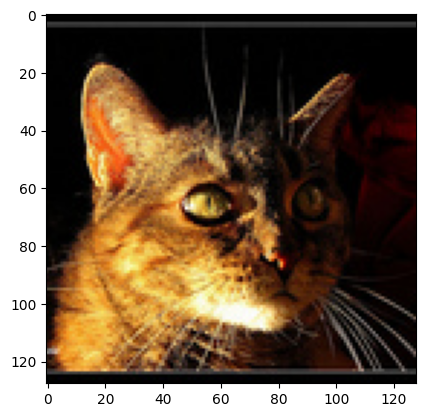

raw: tensor([[ -2.8117, -15.6644, -17.4338, -17.0171, -15.3740,  -8.4053, -15.4631,
          -1.5290, -16.1240,  -0.1237,  -2.1501, -17.2437, -17.0206,  -8.0355]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[5.6696e-02, 1.5741e-07, 2.6828e-08, 4.0699e-08, 2.1046e-07, 2.2364e-04,
         1.9252e-07, 1.7815e-01, 9.9410e-08, 4.6911e-01, 1.0432e-01, 3.2444e-08,
         4.0557e-08, 3.2366e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


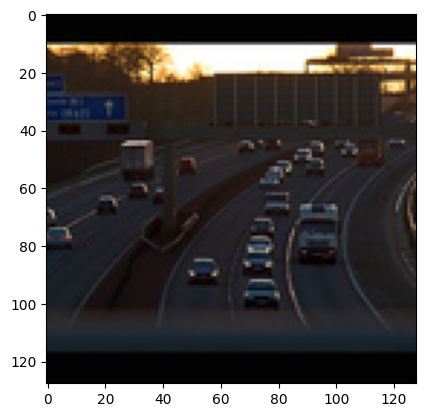

raw: tensor([[ -6.0615, -13.2254, -14.8221, -14.1420, -13.4556,  -9.4803, -13.0238,
          -4.6360, -13.4723,  -1.8658,  -2.7291, -14.5323, -14.2066,  -7.0310]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[2.3256e-03, 1.8042e-06, 3.6547e-07, 7.2144e-07, 1.4332e-06, 7.6333e-05,
         2.2072e-06, 9.6030e-03, 1.4094e-06, 1.3403e-01, 6.1277e-02, 4.8831e-07,
         6.7631e-07, 8.8324e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


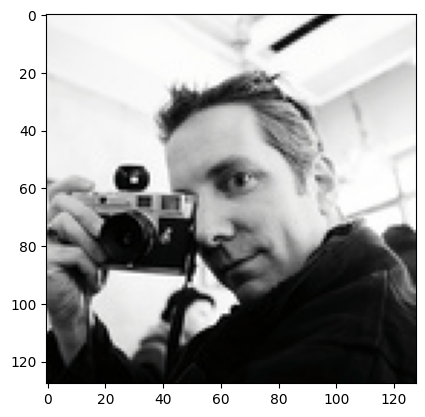

raw: tensor([[ -5.5875, -13.7433, -15.7805, -15.1629, -14.1058,  -7.9023, -13.6361,
          -7.0882, -14.0602,  -3.1124,  -3.0391, -15.6320, -15.3991,  -6.4301]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[3.7303e-03, 1.0749e-06, 1.4016e-07, 2.5992e-07, 7.4802e-07, 3.6974e-04,
         1.1966e-06, 8.3422e-04, 7.8292e-07, 4.2597e-02, 4.5690e-02, 1.6260e-07,
         2.0524e-07, 1.6097e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


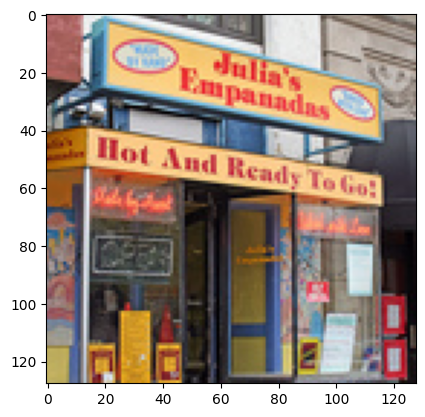

raw: tensor([[-0.0170, -5.8993, -6.4965, -6.3122, -5.9906, -2.3761, -5.8033,  0.0535,
         -5.9926,  1.2971,  0.9181, -6.4004, -6.3456, -3.8233]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4958, 0.0027, 0.0015, 0.0018, 0.0025, 0.0850, 0.0030, 0.5134, 0.0025,
         0.7854, 0.7147, 0.0017, 0.0018, 0.0214]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]], dtype=torch.int32)


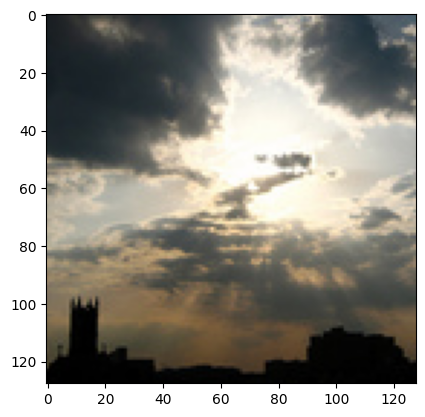

raw: tensor([[-4.1084, -6.3640, -7.0272, -6.8372, -6.3446, -2.5820, -6.4405, -3.1165,
         -6.5346, -1.3220, -1.6089, -6.9765, -6.9329, -3.7009]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0162, 0.0017, 0.0009, 0.0011, 0.0018, 0.0703, 0.0016, 0.0424, 0.0015,
         0.2105, 0.1667, 0.0009, 0.0010, 0.0241]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


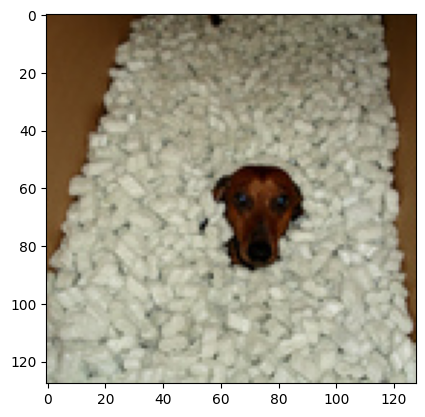

raw: tensor([[-3.6670, -4.8427, -5.4678, -5.3299, -4.9517, -2.6295, -4.8285, -3.1061,
         -4.9742, -0.9668, -0.3063, -5.4021, -5.3333, -2.8348]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0249, 0.0078, 0.0042, 0.0048, 0.0070, 0.0673, 0.0079, 0.0429, 0.0069,
         0.2755, 0.4240, 0.0045, 0.0048, 0.0555]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


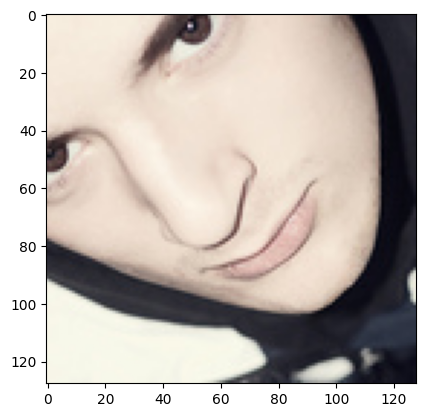

raw: tensor([[-4.9432, -6.8142, -7.1981, -7.0581, -6.9203, -1.7980, -6.7280, -3.3050,
         -6.9010, -1.6977, -2.4970, -7.1314, -7.0209, -3.5762]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0071, 0.0011, 0.0007, 0.0009, 0.0010, 0.1421, 0.0012, 0.0354, 0.0010,
         0.1548, 0.0761, 0.0008, 0.0009, 0.0272]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


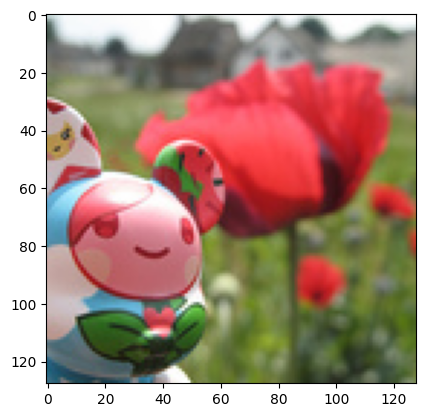

raw: tensor([[ -6.5164, -12.0208, -14.1460, -13.5237, -12.1426,  -7.0159, -11.9691,
          -5.8874, -12.4389,  -2.5763,  -4.4952, -13.9288, -13.6719,  -6.0853]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.4769e-03, 6.0177e-06, 7.1859e-07, 1.3389e-06, 5.3279e-06, 8.9671e-04,
         6.3369e-06, 2.7665e-03, 3.9612e-06, 7.0680e-02, 1.1039e-02, 8.9286e-07,
         1.1544e-06, 2.2710e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


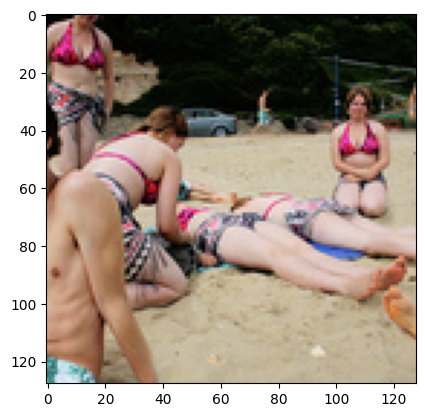

raw: tensor([[ -8.9514, -30.6520, -33.0912, -32.5300, -30.5466, -16.2271, -30.2025,
          -0.8814, -31.4363,  -2.1492,   0.7880, -32.8257, -32.3701, -17.7404]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.2954e-04, 4.8755e-14, 4.2526e-15, 7.4542e-15, 5.4173e-14, 8.9671e-08,
         7.6420e-14, 2.9289e-01, 2.2254e-14, 1.0441e-01, 6.8741e-01, 5.5460e-15,
         8.7470e-15, 1.9745e-08]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=torch.int32)


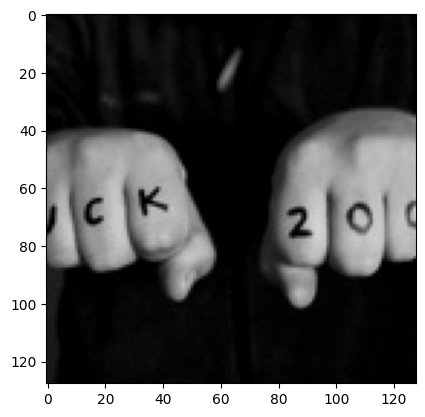

raw: tensor([[ -7.0772, -17.8415, -19.3783, -18.8899, -17.9963,  -7.8559, -17.5661,
          -5.8878, -18.0423,  -3.0221,  -6.1291, -19.1927, -18.8712,  -8.4964]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[8.4339e-04, 1.7845e-08, 3.8381e-09, 6.2551e-09, 1.5286e-08, 3.8731e-04,
         2.3505e-08, 2.7655e-03, 1.4599e-08, 4.6436e-02, 2.1738e-03, 4.6210e-09,
         6.3732e-09, 2.0416e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


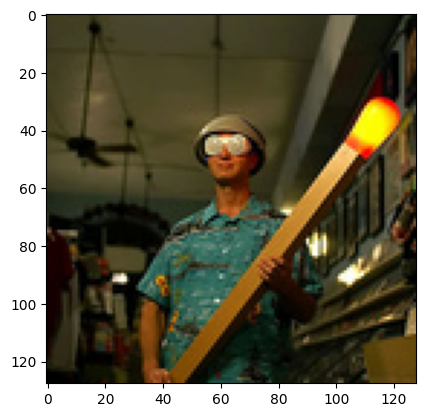

raw: tensor([[ -6.3015, -26.2575, -28.9319, -28.2565, -26.5514, -13.1241, -25.4431,
          -3.1604, -26.6061,  -0.3397,  -1.8266, -28.5989, -28.0764, -12.9952]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.8303e-03, 3.9493e-12, 2.7228e-13, 5.3499e-13, 2.9435e-12, 1.9966e-06,
         8.9167e-12, 4.0684e-02, 2.7868e-12, 4.1588e-01, 1.3864e-01, 3.7990e-13,
         6.4058e-13, 2.2713e-06]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


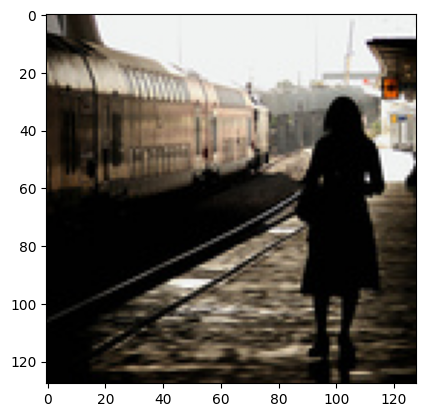

raw: tensor([[-4.2568, -8.5751, -9.4164, -9.2069, -8.7289, -5.6662, -8.4752, -4.7077,
         -8.7110, -2.3413, -1.9792, -9.3261, -9.1896, -3.6114]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.3970e-02, 1.8871e-04, 8.1375e-05, 1.0034e-04, 1.6182e-04, 3.4491e-03,
         2.0854e-04, 8.9448e-03, 1.6474e-04, 8.7761e-02, 1.2140e-01, 8.9065e-05,
         1.0209e-04, 2.6303e-02]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


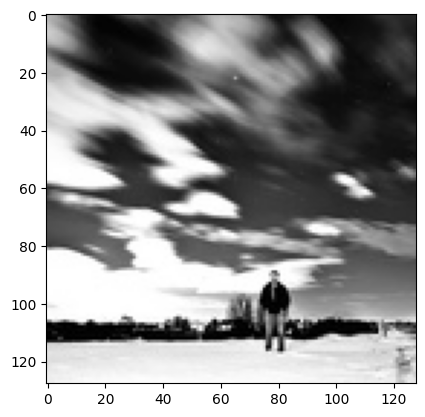

raw: tensor([[ -2.5443, -13.1696, -16.7457, -15.7693, -13.5843, -11.6106, -12.9020,
          -8.1412, -13.6793,  -0.2912,  -0.5730, -16.3804, -15.9334,  -4.8593]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[7.2808e-02, 1.9077e-06, 5.3389e-08, 1.4174e-07, 1.2601e-06, 9.0697e-06,
         2.4930e-06, 2.9121e-04, 1.1459e-06, 4.2771e-01, 3.6055e-01, 7.6927e-08,
         1.2028e-07, 7.6963e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


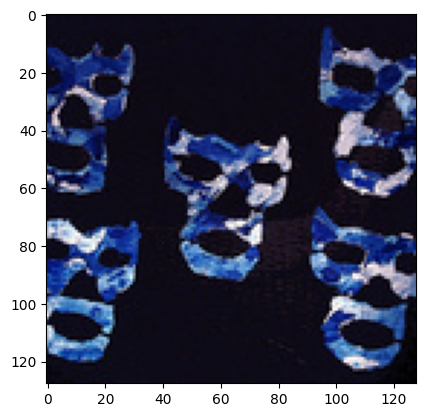

raw: tensor([[ -4.0951, -10.7559, -12.9886, -12.4701, -10.7506,  -6.6647, -10.5264,
          -5.4519, -11.1670,  -1.0435,  -2.6369, -12.6831, -12.4174,  -4.8974]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.6382e-02, 2.1318e-05, 2.2863e-06, 3.8396e-06, 2.1432e-05, 1.2735e-03,
         2.6818e-05, 4.2697e-03, 1.4133e-05, 2.6047e-01, 6.6803e-02, 3.1030e-06,
         4.0473e-06, 7.4110e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


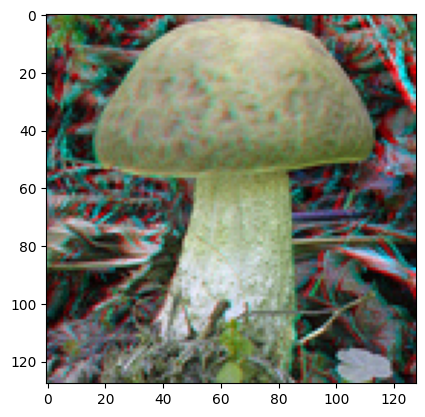

raw: tensor([[-3.5472, -4.9561, -5.2591, -5.0626, -5.0716, -3.5501, -4.8893, -2.5199,
         -5.0097, -1.5749, -1.2727, -5.1474, -5.0647, -2.7097]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.0280, 0.0070, 0.0052, 0.0063, 0.0062, 0.0279, 0.0075, 0.0745, 0.0066,
         0.1715, 0.2188, 0.0058, 0.0063, 0.0624]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


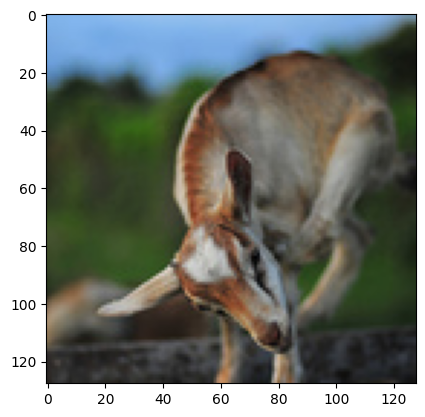

raw: tensor([[ -5.7158,  -9.7098, -10.7731, -10.3774,  -9.5632,  -2.8645,  -9.6001,
          -4.4416,  -9.8174,  -1.1688,  -2.9556, -10.7471, -10.6340,  -4.9533]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[3.2827e-03, 6.0684e-05, 2.0955e-05, 3.1126e-05, 7.0260e-05, 5.3936e-02,
         6.7715e-05, 1.1640e-02, 5.4491e-05, 2.3708e-01, 4.9474e-02, 2.1506e-05,
         2.4083e-05, 7.0102e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


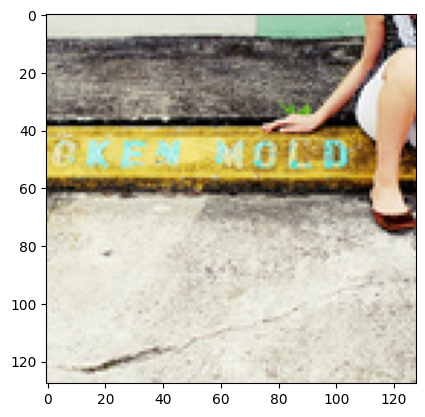

raw: tensor([[ -3.2342, -10.2451, -12.1141, -11.5882, -10.2374,  -6.1941, -10.1265,
          -4.3086, -10.4976,  -0.7640,  -2.0246, -11.9694, -11.7260,  -4.7948]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[3.7901e-02, 3.5531e-05, 5.4816e-06, 9.2744e-06, 3.5803e-05, 2.0373e-03,
         4.0004e-05, 1.3274e-02, 2.7601e-05, 3.1778e-01, 1.1664e-01, 6.3352e-06,
         8.0808e-06, 8.2051e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


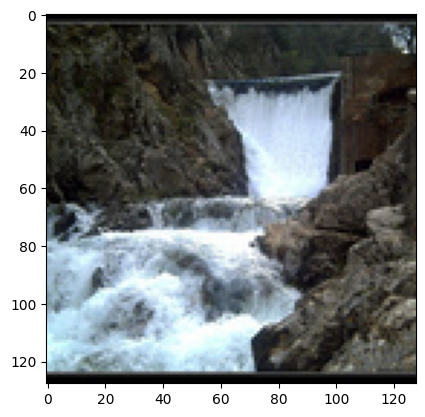

raw: tensor([[ -6.9273, -15.0658, -16.9720, -16.3368, -15.1933,  -7.2884, -14.7228,
          -7.3028, -15.3360,  -3.4606,  -5.8075, -16.7240, -16.4986,  -5.5359]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[9.7972e-04, 2.8641e-07, 4.2575e-08, 8.0355e-08, 2.5213e-07, 6.8293e-04,
         4.0363e-07, 6.7317e-04, 2.1861e-07, 3.0453e-02, 2.9959e-03, 5.4557e-08,
         6.8352e-08, 3.9270e-03]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


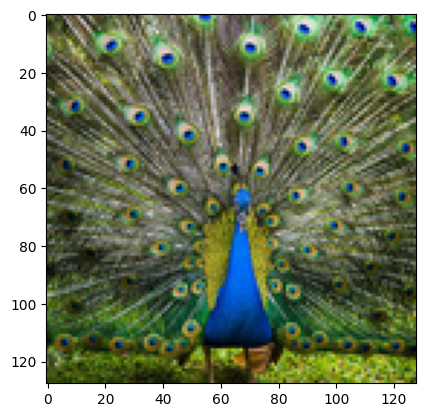

raw: tensor([[ -0.2554, -11.7030, -12.3282, -12.1919, -11.7916,  -4.8733, -11.5208,
           3.1286, -11.8074,   4.9024,   4.0878, -12.2515, -12.1137,  -7.8619]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[4.3650e-01, 8.2690e-06, 4.4251e-06, 5.0712e-06, 7.5678e-06, 7.5903e-03,
         9.9216e-06, 9.5806e-01, 7.4491e-06, 9.9263e-01, 9.8350e-01, 4.7778e-06,
         5.4838e-06, 3.8498e-04]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]], dtype=torch.int32)


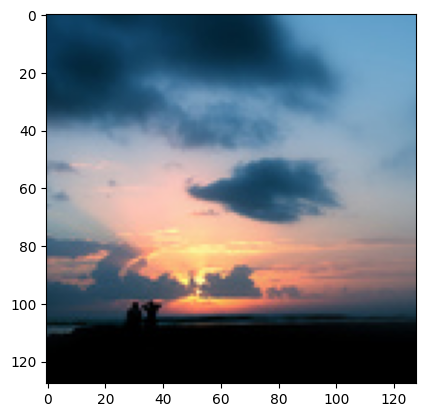

raw: tensor([[ -8.6722, -22.5357, -25.8621, -24.9542, -23.0089, -14.8791, -22.2583,
         -11.9931, -22.9400,  -4.0261,  -4.2175, -25.6461, -25.2227, -10.0478]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[1.7125e-04, 1.6325e-10, 5.8643e-12, 1.4539e-11, 1.0171e-10, 3.4522e-07,
         2.1545e-10, 6.1868e-06, 1.0897e-10, 1.7531e-02, 1.4521e-02, 7.2782e-12,
         1.1115e-11, 4.3280e-05]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


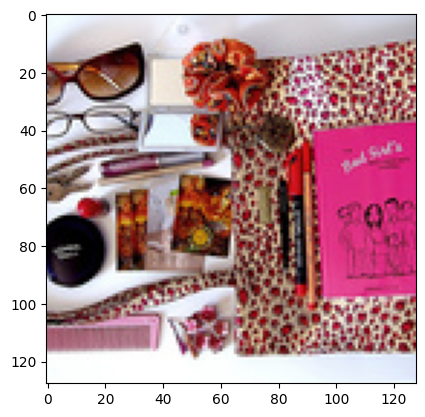

In [40]:
def testN(num_pics):
    test_total = 0
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    for i, data in enumerate(test_loader):
        test_total += 1
        if test_total > num_pics:
            break
        input, label, index, path = data
        input, label = input.to(device), label.to(device)
        output = model.forward(input)
        predictions = (torch.sigmoid(output) > 0.5).int()
        print(f'raw: {output}, sigmoid: {torch.sigmoid(output)}')
        print(['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree'])
        print('label',label)
        print()
        print('pred', predictions)

        image_array = input.numpy()
        plt.imshow(image_array.transpose((2, 3, 1, 0)).squeeze(3))
        plt.show()


testN(25)